# Model Validation: Banding Noise Removal
This notebook loads the trained `SimpleUNet` model and visualizes its performance on the validation dataset.

In [1]:
# 1. Import Libraries and Setup Environment
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Ensure local modules can be imported
sys.path.append(os.getcwd())

from model import SimpleUNet
from data_utils import BandingNoiseDataset
from torch.utils.data import DataLoader

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# 2. Define Model Structure and Load Weights
MODEL_PATH = "model_final.pth"

# Initialize model
model = SimpleUNet().to(device)

# Load weights
if os.path.exists(MODEL_PATH):
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        print(f"Successfully loaded weights from '{MODEL_PATH}'")
    except Exception as e:
        print(f"Error loading weights: {e}")
else:
    print(f"Warning: '{MODEL_PATH}' not found. Please check the file path.")

# Set model to evaluation mode
model.eval()

Successfully loaded weights from 'model_final.pth'


SimpleUNet(
  (enc1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (enc2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (enc3): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), strid

In [3]:
# 3. Configure Validation Dataset and DataLoader
VAL_DIR = './Validation/01.Photo/VS_Comb_Light_01.AVG'

if not os.path.exists(VAL_DIR):
    print(f"Warning: Validation directory '{VAL_DIR}' does not exist.")
    # Create a dummy dataset for demonstration if path is missing (optional)
    val_loader = None
else:
    # Create dataset instance
    # Using resize to match training dimensions or for faster visualization
    val_dataset = BandingNoiseDataset(
        root_dir=VAL_DIR, 
        transform=None, 
        resize=(1280, 720) 
    )

    # Create DataLoader with batch_size=1 for individual image inspection
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
    print(f"Validation dataset loaded. Total images: {len(val_dataset)}")

Validation dataset loaded. Total images: 7574


In [4]:
# 4. Define Visualization Helper Function
def visualize_results(noisy_input, clean_target, restored_output):
    """
    Visualizes the Noisy Input (Center Frame), Restored Output, and Clean Target.
    """
    # Convert tensors to numpy arrays (B, C, H, W) -> (H, W, C)
    # We take the first item in the batch [0]
    
    # Input is 9 channels (t-1, t, t+1). We extract the center frame (channels 3:6) for display.
    noisy_np = noisy_input[0].cpu().numpy().transpose(1, 2, 0)
    noisy_center_frame = noisy_np[:, :, 3:6] 
    
    clean_np = clean_target[0].cpu().numpy().transpose(1, 2, 0)
    restored_np = restored_output[0].cpu().numpy().transpose(1, 2, 0)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    
    # 1. Noisy Input
    axes[0].imshow(np.clip(noisy_center_frame, 0, 1))
    axes[0].set_title("Noisy Input (Frame t)")
    axes[0].axis('off')
    
    # 2. Restored Output
    axes[1].imshow(np.clip(restored_np, 0, 1))
    axes[1].set_title("Restored Output (Model Prediction)")
    axes[1].axis('off')
    
    # 3. Clean Target
    axes[2].imshow(np.clip(clean_np, 0, 1))
    axes[2].set_title("Clean Target (Ground Truth)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

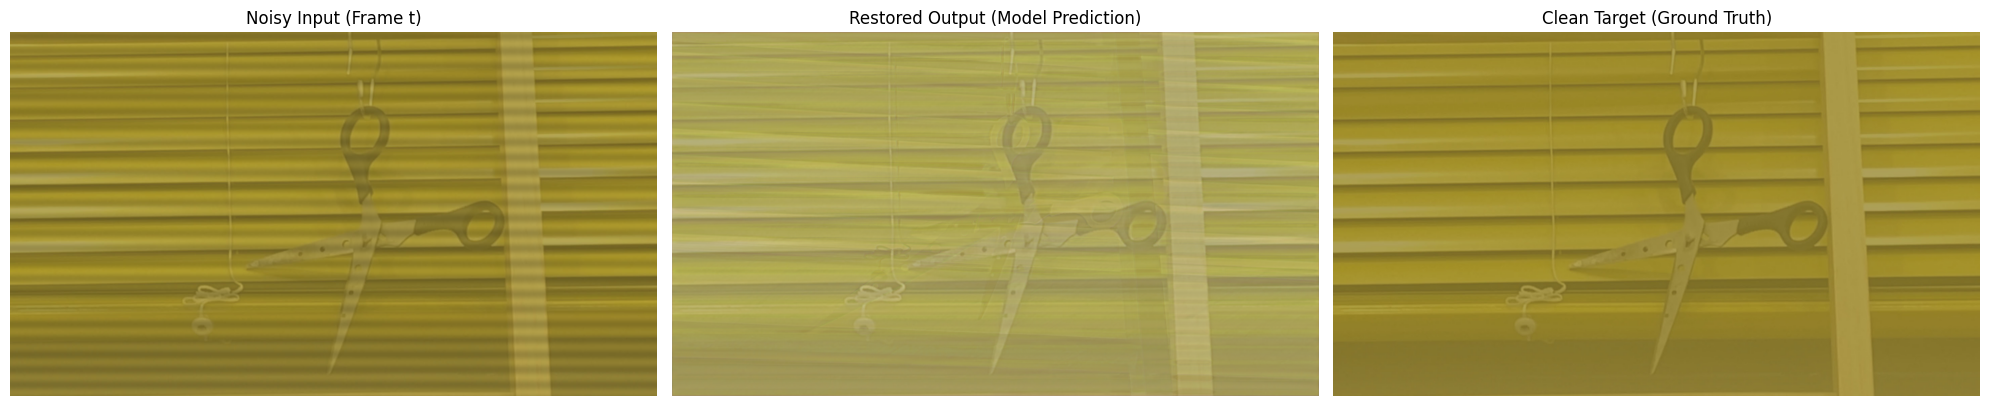

In [5]:
# 5. Run Inference and Compare Results
if val_loader:
    # Get a single batch of data
    noisy_input_9ch, clean_t, _ = next(iter(val_loader))
    
    # Move to device
    noisy_input_9ch = noisy_input_9ch.to(device)
    
    # Inference
    with torch.no_grad():
        output_t = model(noisy_input_9ch)
    
    # Visualize
    visualize_results(noisy_input_9ch, clean_t, output_t)
else:
    print("Validation loader is not ready. Check the dataset path.")